# Water test
--

# Import Dependancies and Data files

In [1]:
#Import dependancies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import json
import urllib.request

import time
from scipy.stats import linregress

In [3]:
#import datafile from CSV sample file and name as a variable (Should be the CSV file we downloaded from CA open data that Adam cleaned up)
ar_data_import = "../CA_Water_Analysis/Mer-Water-Lab-Data.csv"
ar_data = pd.read_csv(ar_data_import)


# Clean Data For Further Analysis

In [4]:
#Clean data by splitting combined date and time from sample_date field into a single date only field.
for idx, row in ar_data.iterrows(): 
    year=row['sample_date'].split(' ')[0].split('/')[-1]
    date=row['sample_date'].split(' ')[0]
    time=row['sample_date'].split(' ')[-1]
    new_date=date.split('/')[:-1]
    new_date=new_date+[f'{year}']
    new_date_str='/'.join(new_date)
    
    ar_data.loc[idx, 'sample_date']=new_date_str


# Isolate Time Segmented Data for further analysis

In [5]:


#convert sample date field to panda date format, print to check
ar_data['sample_date'] = pd.to_datetime(ar_data['sample_date'])

# Create DataFrame for 2012 to 2022
ar_data_df = pd.DataFrame(ar_data)
start_date = '2012-01-01'
end_date = '2022-12-31'
mask = (ar_data_df['sample_date'] > start_date) & (ar_data_df['sample_date'] <= end_date)
  
ar_data_df = ar_data_df.loc[mask]


ar_data_df.head()

,station_id,station_name,full_station_name,station_number,station_type,latitude,longitude,status,county_name,sample_code,sample_date,sample_depth,sample_depth_units,parameter,result,reporting_limit,units,method_name
39,259,Del Valle COW,Del Valle Conserv. Outlet Works,DV000000,Surface Water,37.6183,121.7494,Review Status Unknown,Alameda,D0116B0008,2016-01-19,1.0,Meters,Dissolved Mercury,0.0,0.0002,ug/L,EPA 200.8 (Hg Dissolved)
40,259,Del Valle COW,Del Valle Conserv. Outlet Works,DV000000,Surface Water,37.6183,121.7494,Review Status Unknown,Alameda,DA0212B3393,2012-02-13,1.0,Meters,Dissolved Mercury,0.0,0.0002,ug/L,EPA 200.8 (Hg Dissolved)
42,259,Del Valle COW,Del Valle Conserv. Outlet Works,DV000000,Surface Water,37.6183,121.7494,Review Status Unknown,Alameda,D0216B0018,2016-02-16,1.0,Meters,Dissolved Mercury,0.0,0.0002,ug/L,EPA 200.8 (Hg Dissolved)
46,259,Del Valle COW,Del Valle Conserv. Outlet Works,DV000000,Surface Water,37.6183,121.7494,Review Status Unknown,Alameda,D0219B0018,2019-02-19,1.0,Meters,Dissolved Mercury,0.0,0.0002,ug/L,EPA 200.8 (Hg Dissolved)
52,259,Del Valle COW,Del Valle Conserv. Outlet Works,DV000000,Surface Water,37.6183,121.7494,Review Status Unknown,Alameda,DA0312B3447,2012-03-19,1.0,Meters,Dissolved Mercury,0.0,0.0002,ug/L,EPA 200.8 (Hg Dissolved)


In [10]:
#count the number of samples for the period
Total_Mercury_Samples = ar_data_df.size

print(f"There were a total of {Total_Mercury_Samples} Water Samples taken for Mercury between 2012 and 2022")

There were a total of 70164 Water Samples taken for Mercury between 2012 and 2022


# Ground Water vs. Surface Water Analysis

In [11]:
#separate ground water from surface water temperatures

#create a dataframe for Ground Water samples
target_sample = ar_data_df["station_type"] == "Groundwater"
ground_df =ar_data_df.loc[target_sample]
ground_avg =ground_df.groupby("sample_date").mean()["result"]
ground_av_df = pd.DataFrame({"Groundwater": ground_avg})

Total_Ground_Samples = ground_df.size

#create a dataframe for Surface Water samples
target_sample = ar_data_df["station_type"] == "Surface Water"
surface_df =ar_data_df.loc[target_sample]
surface_avg =surface_df.groupby("sample_date").mean()["result"]
surface_av_df = pd.DataFrame({"Surface Water": surface_avg})

Total_Surface_Samples = surface_df.size




In [13]:
print(f"There were a total of {Total_Ground_Samples} Ground Samples and {Total_Surface_Samples} taken for Mercury between 2012 and 2022")

There were a total of 1494 Ground Samples and 68130 taken for Mercury between 2012 and 2022


In [36]:
# Generate a bar plot showing the total number of timepoints for all stations tested based on surface or ground water using pyplot.

type = ['Ground','Surface']
timepoints_2 = ar_data_df.groupby('sample_date')['result'].count()
x_axis = np.arange(len(timepoints_2))
ticks = [value+0.1 for value in x_axis]
plt.figure(figsize=(8,6))
plt.bar(x_axis, timepoints_2, color='green', alpha=1, align='edge', width=0.6)
plt.xticks(ticks, type, rotation='vertical')
plt.title('test')
plt.xlabel('Station Type')
plt.ylabel('Timeline')


SyntaxError: invalid syntax (274598291.py, line 3)

In [14]:
#sort by the total amount of arsenic found (need to double check that all these values have been converted)
sorted_recent_df = ar_data_df.sort_values(['result'], ascending=False)

#create a new dataframe from 500 top offenders--this can be a variable
top_offender_df = sorted_recent_df.head(1500)


#Find out who they are
total_dirty_counties = top_offender_df['county_name'].unique()
print(total_dirty_counties)

['Los Angeles' 'Yolo' 'Kern' 'Merced' 'Riverside' 'San Bernardino'
 'Tehama' 'Shasta' 'Yuba' 'Lake' 'Humboldt' 'Colusa' 'Sutter' 'Solano'
 'Butte' 'Modoc' 'Glenn' 'Sacramento' 'Plumas' 'Lassen' 'Del Norte'
 'Mendocino' 'Siskiyou' 'Trinity']


In [15]:
#create a new dataframe of the county offenders and count how many samples there are

county_df=sorted_recent_df.loc[(sorted_recent_df["county_name"] == "Kern") |
                              (sorted_recent_df["county_name"] == "Tehama") |
                              (sorted_recent_df["county_name"] == "Glen") |
                              (sorted_recent_df["county_name"] == "Shasta") |
                              (sorted_recent_df["county_name"] == "Modoc") |
                              (sorted_recent_df["county_name"] == "Los Angeles") |
                              (sorted_recent_df["county_name"] == "Alameda") |
                              (sorted_recent_df["county_name"] == "San Bernardino")]

county_df.size

23634

# County by County Analysis

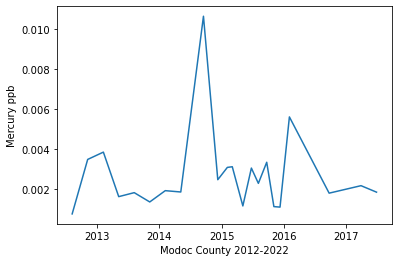

In [51]:
#create a dataframe for Modoc County
Target_County = county_df["county_name"] == "Modoc"
Target_County_df =county_df.loc[Target_County]
Target_County_avg =Target_County_df.groupby("sample_date").mean()["result"]
Target_County_av_df = pd.DataFrame({"Modoc": Target_County_avg})

#plot a chart with the dataframe

plt.plot(Target_County_av_df)
plt.show
#plt.bar(x_axis, Target_County, color='green', alpha=1, align='edge', width=0.6)
#plt.xticks(ticks, type, rotation='vertical')
plt.title = ('Average Mercury Level 2012-2022')
plt.xlabel('Modoc County 2012-2022')
plt.ylabel('Mercury ppb')
#count total samples & create a variable to hold it
Modoc_Total_Samples = Target_County_av_df.size

#print(f"There were a total of {Modoc_Total_Samples} Mercury Samples taken for Modoc County between 2012 and in 2022")



Text(0, 0.5, 'Mercury ppb')

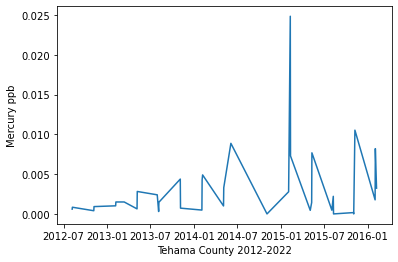

In [52]:
#create a dataframe for Tehama county
Target_County = county_df["county_name"] == "Tehama"
Target_County_df =county_df.loc[Target_County]
Target_County_avg =Target_County_df.groupby("sample_date").mean()["result"]
Target_County_av_df = pd.DataFrame({"Tehama": Target_County_avg})
Tehama_Total_Samples = Target_County_av_df.size

#print(f"There were a total of {Tehama_Total_Samples} Mercury Samples taken for Tehama County between 2012 and in 2022")

#plot a chart with the dataframe

plt.plot(Target_County_av_df)
plt.show
#plt.bar(x_axis, Target_County, color='green', alpha=1, align='edge', width=0.6)
#plt.xticks(ticks, type, rotation='vertical')
plt.title = ('Average Mercury Level 2012-2022')
plt.xlabel('Tehama County 2012-2022')
plt.ylabel('Mercury ppb')

In [19]:
#plot San Bernadino county
Target_County = county_df["county_name"] == "San Bernardino"
Target_County_df =county_df.loc[Target_County]
Target_County_avg =Target_County_df.groupby("sample_date").mean()["result"]
Target_County_av_df = pd.DataFrame({"San Bernardino": Target_County_avg})
SanBern_Total_Samples = Target_County_df.size

print(f"There were a total of {SanBern_Total_Samples} Mercury Samples taken for San Bernardino County between 2012 and in 2022")


There were a total of 4446 Mercury Samples taken for San Bernardino County between 2012 and in 2022


In [20]:
#plot Kern county
Kern_df = county_df.loc[county_df["county_name"] == "Kern"]
Kern_avg = Kern_df.groupby("sample_date").mean()["result"]
Kern_av_df = pd.DataFrame({"Kern": Kern_avg})
Kern_Total_Samples = Kern_df.size

#print(f"There were a total of {Kern_Total_Samples} Mercury Samples for Kern County from 2012 to 2022")


There were a total of 4482 Mercury Samples for Kern County from 2012 to 2022


In [21]:
#plot Alameda county
Target_County = county_df["county_name"] == "Alameda"
Target_County_df =county_df.loc[Target_County]
Target_County_avg =Target_County_df.groupby("sample_date").mean()["result"]
Target_County_av_df = pd.DataFrame({"Alameda": Target_County_avg})

Target_County_df.size

4914

In [22]:
#create a list of all counties
countys =[]
countys = ['Sacramento', 'Kern', 'Butte', 'Lassen', 'Shasta', 'Tehama', 'Modoc', 'Glenn',
 'Colusa', 'Alpine', 'Humboldt', 'Mendocino','Lake','Trinity', 'Siskiyou',
 'Sutter', 'Plumas', 'Mono', 'Los Angeles', 'Yolo', 'San Bernardino', 'Sierra',
 'Alameda', 'Merced', 'Solano' ,'Contra Costa', 'Kings', 'Del Norte',
 'Riverside', 'San Joaquin', 'Yuba', 'Tulare', 'Inyo', 'Imperial', 'El Dorado',
 'Santa Cruz', 'Napa', 'Monterey', 'Fresno', 'San Diego', 'Calaveras', 'Amador',
 'Sonoma', 'Santa Clara', 'Tuolumne', 'Placer', 'Ventura', 'San Luis Obispo',
 'Santa Barbara', 'Nevada', 'Orange', 'Stanislaus', 'Madera', 'San Mateo',
 'San Francisco', 'San Benito', 'Mariposa']
#print the counties as a list

countys

    


['Sacramento',
 'Kern',
 'Butte',
 'Lassen',
 'Shasta',
 'Tehama',
 'Modoc',
 'Glenn',
 'Colusa',
 'Alpine',
 'Humboldt',
 'Mendocino',
 'Lake',
 'Trinity',
 'Siskiyou',
 'Sutter',
 'Plumas',
 'Mono',
 'Los Angeles',
 'Yolo',
 'San Bernardino',
 'Sierra',
 'Alameda',
 'Merced',
 'Solano',
 'Contra Costa',
 'Kings',
 'Del Norte',
 'Riverside',
 'San Joaquin',
 'Yuba',
 'Tulare',
 'Inyo',
 'Imperial',
 'El Dorado',
 'Santa Cruz',
 'Napa',
 'Monterey',
 'Fresno',
 'San Diego',
 'Calaveras',
 'Amador',
 'Sonoma',
 'Santa Clara',
 'Tuolumne',
 'Placer',
 'Ventura',
 'San Luis Obispo',
 'Santa Barbara',
 'Nevada',
 'Orange',
 'Stanislaus',
 'Madera',
 'San Mateo',
 'San Francisco',
 'San Benito',
 'Mariposa']

In [23]:
#Create a list of Dirty Counties
#create a list of all counties
dirty_countys = []
dirty_countys = total_dirty_counties

dirty_countys


array(['Los Angeles', 'Yolo', 'Kern', 'Merced', 'Riverside',
       'San Bernardino', 'Tehama', 'Shasta', 'Yuba', 'Lake', 'Humboldt',
       'Colusa', 'Sutter', 'Solano', 'Butte', 'Modoc', 'Glenn',
       'Sacramento', 'Plumas', 'Lassen', 'Del Norte', 'Mendocino',
       'Siskiyou', 'Trinity'], dtype=object)

In [24]:
dirty_countys.size



24

<function matplotlib.pyplot.show(close=None, block=None)>

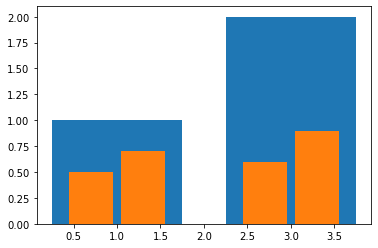

In [25]:
plt.title = ('sample chart')
y1 = [1, 2]
x1 = [1, 3]

y2 = [0.5, 0.7, 0.6, 0.9]
x2 = [0.7, 1.3, 2.7, 3.3]

plt.bar(x1, y1, width=1.5)
plt.bar(x2, y2, width=0.5)

plt.show
